In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate, multiply

In [0]:
file_import = drive.CreateFile({'id':'1gV3lTGPAL-x0c-EqZXyF4saHo7AVLN4j'})
file_import.GetContentFile('AttentionWithContext.py') 

from AttentionWithContext import AttentionWithContext

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor_attentive(filtersNumber, inputLayer):
    
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    attention_layer = AttentionWithContext()(block_1_conv_1)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)
    block_1_max_pool1 = multiply([attention_layer, block_1_max_pool1])

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    attention_layer = AttentionWithContext()(block_1_conv_2)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)
    block_1_max_pool2 = multiply([attention_layer, block_1_max_pool2])

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    attention_layer = AttentionWithContext()(block_1_conv_3)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_conv_3)
    block_1_max_pool3 = multiply([attention_layer, block_1_max_pool3])
    
    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    attention_layer = AttentionWithContext()(block_1_conv_4)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)
    block_1_max_pool4 = multiply([attention_layer, block_1_max_pool4])
    
    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [11]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor_attentive(filtersNumber, features_3)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________

In [12]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21408/102124 [=====>........................] - ETA: 6:40 - loss: 0.1810 - acc: 0.9317

102112/102124 [============================>.] - ETA: 0s - loss: 0.0886 - acc: 0.9676

102124/102124 [==============================] - 527s 5ms/step - loss: 0.0886 - acc: 0.9676 - val_loss: 0.0518 - val_acc: 0.9816
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 7:01 - loss: 0.0569 - acc: 0.9796

102112/102124 [============================>.] - ETA: 0s - loss: 0.0566 - acc: 0.9793

102124/102124 [==============================] - 523s 5ms/step - loss: 0.0566 - acc: 0.9793 - val_loss: 0.0488 - val_acc: 0.9823
roc-auc: 0.9768 - roc-auc_val: 0.9758                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 7:26 - loss: 0.0550 - acc: 0.9789

102112/102124 [============================>.] - ETA: 0s - loss: 0.0526 - acc: 0.9804

102124/102124 [==============================] - 523s 5ms/step - loss: 0.0526 - acc: 0.9804 - val_loss: 0.0484 - val_acc: 0.9829
Epoch 4/32
 14048/102124 [===>..........................] - ETA: 7:01 - loss: 0.0494 - acc: 0.9814

102112/102124 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9813

102124/102124 [==============================] - 523s 5ms/step - loss: 0.0497 - acc: 0.9813 - val_loss: 0.0450 - val_acc: 0.9832
roc-auc: 0.9832 - roc-auc_val: 0.98                                                                                                    
Epoch 5/32
  8768/102124 [=>............................] - ETA: 7:26 - loss: 0.0465 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9819

102124/102124 [==============================] - 523s 5ms/step - loss: 0.0481 - acc: 0.9819 - val_loss: 0.0450 - val_acc: 0.9833
Epoch 6/32
 14048/102124 [===>..........................] - ETA: 7:01 - loss: 0.0454 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9822

102124/102124 [==============================] - 523s 5ms/step - loss: 0.0465 - acc: 0.9822 - val_loss: 0.0439 - val_acc: 0.9841
roc-auc: 0.9844 - roc-auc_val: 0.9809                                                                                                    
Epoch 7/32
  8736/102124 [=>............................] - ETA: 7:26 - loss: 0.0425 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9826

102124/102124 [==============================] - 523s 5ms/step - loss: 0.0455 - acc: 0.9826 - val_loss: 0.0426 - val_acc: 0.9837
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 7:01 - loss: 0.0450 - acc: 0.9822

102112/102124 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9829

102124/102124 [==============================] - 523s 5ms/step - loss: 0.0443 - acc: 0.9829 - val_loss: 0.0421 - val_acc: 0.9841
roc-auc: 0.9885 - roc-auc_val: 0.9847                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 7:26 - loss: 0.0438 - acc: 0.9828

102112/102124 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9831

102124/102124 [==============================] - 523s 5ms/step - loss: 0.0436 - acc: 0.9831 - val_loss: 0.0425 - val_acc: 0.9837
Epoch 10/32
 13984/102124 [===>..........................] - ETA: 7:00 - loss: 0.0423 - acc: 0.9832

102112/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9833

102124/102124 [==============================] - 522s 5ms/step - loss: 0.0425 - acc: 0.9833 - val_loss: 0.0416 - val_acc: 0.9842
roc-auc: 0.9894 - roc-auc_val: 0.9866                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 7:26 - loss: 0.0415 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9836

102124/102124 [==============================] - 523s 5ms/step - loss: 0.0419 - acc: 0.9836 - val_loss: 0.0437 - val_acc: 0.9840
Epoch 12/32
 13984/102124 [===>..........................] - ETA: 7:01 - loss: 0.0412 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9837

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0416 - acc: 0.9837 - val_loss: 0.0417 - val_acc: 0.9844

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0001593200722709298.
roc-auc: 0.989 - roc-auc_val: 0.987                                                                                                    
Epoch 13/32
  5984/102124 [>.............................] - ETA: 7:40 - loss: 0.0399 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9838

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0410 - acc: 0.9838 - val_loss: 0.0408 - val_acc: 0.9844
Epoch 14/32
 13984/102124 [===>..........................] - ETA: 7:01 - loss: 0.0407 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9840

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0403 - acc: 0.9840 - val_loss: 0.0412 - val_acc: 0.9842
roc-auc: 0.9884 - roc-auc_val: 0.985                                                                                                    
Epoch 15/32
  8736/102124 [=>............................] - ETA: 7:27 - loss: 0.0374 - acc: 0.9849

102112/102124 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9841

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0400 - acc: 0.9841 - val_loss: 0.0408 - val_acc: 0.9842
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 7:02 - loss: 0.0397 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9844

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0394 - acc: 0.9844 - val_loss: 0.0405 - val_acc: 0.9846
roc-auc: 0.9915 - roc-auc_val: 0.9878                                                                                                    
Epoch 17/32
  8704/102124 [=>............................] - ETA: 7:27 - loss: 0.0374 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9844

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0390 - acc: 0.9844 - val_loss: 0.0404 - val_acc: 0.9846
Epoch 18/32
 13984/102124 [===>..........................] - ETA: 7:01 - loss: 0.0382 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9845

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0385 - acc: 0.9845 - val_loss: 0.0401 - val_acc: 0.9845
roc-auc: 0.9904 - roc-auc_val: 0.9873                                                                                                    
Epoch 19/32
  8704/102124 [=>............................] - ETA: 7:27 - loss: 0.0402 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9845

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0383 - acc: 0.9845 - val_loss: 0.0409 - val_acc: 0.9845
Epoch 20/32
 13984/102124 [===>..........................] - ETA: 7:02 - loss: 0.0382 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9848

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0380 - acc: 0.9848 - val_loss: 0.0403 - val_acc: 0.9845
roc-auc: 0.9914 - roc-auc_val: 0.9878                                                                                                    
Epoch 21/32
  8704/102124 [=>............................] - ETA: 7:28 - loss: 0.0368 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9847

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0380 - acc: 0.9847 - val_loss: 0.0407 - val_acc: 0.9847
Epoch 22/32
 13984/102124 [===>..........................] - ETA: 7:01 - loss: 0.0362 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9850

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0374 - acc: 0.9850 - val_loss: 0.0406 - val_acc: 0.9845
roc-auc: 0.9922 - roc-auc_val: 0.9874                                                                                                    
Epoch 23/32
  8704/102124 [=>............................] - ETA: 7:28 - loss: 0.0385 - acc: 0.9848

102112/102124 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9851

102124/102124 [==============================] - 525s 5ms/step - loss: 0.0369 - acc: 0.9851 - val_loss: 0.0406 - val_acc: 0.9845

Epoch 00023: ReduceLROnPlateau reducing learning rate to 5.076577508589253e-05.
Epoch 24/32
  8032/102124 [=>............................] - ETA: 7:31 - loss: 0.0366 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9851

102124/102124 [==============================] - 525s 5ms/step - loss: 0.0368 - acc: 0.9851 - val_loss: 0.0417 - val_acc: 0.9845
roc-auc: 0.9876 - roc-auc_val: 0.9829                                                                                                    
Epoch 25/32
  8704/102124 [=>............................] - ETA: 7:27 - loss: 0.0384 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9852

102124/102124 [==============================] - 525s 5ms/step - loss: 0.0369 - acc: 0.9852 - val_loss: 0.0403 - val_acc: 0.9847
Epoch 26/32
 13984/102124 [===>..........................] - ETA: 7:03 - loss: 0.0353 - acc: 0.9858

102112/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9854

102124/102124 [==============================] - 525s 5ms/step - loss: 0.0363 - acc: 0.9854 - val_loss: 0.0409 - val_acc: 0.9844
roc-auc: 0.9907 - roc-auc_val: 0.9866                                                                                                    
Epoch 27/32
  8704/102124 [=>............................] - ETA: 7:27 - loss: 0.0367 - acc: 0.9849

102112/102124 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9852

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0365 - acc: 0.9852 - val_loss: 0.0410 - val_acc: 0.9844
Epoch 28/32
 13984/102124 [===>..........................] - ETA: 7:01 - loss: 0.0349 - acc: 0.9857

102112/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9853

102124/102124 [==============================] - 524s 5ms/step - loss: 0.0363 - acc: 0.9853 - val_loss: 0.0420 - val_acc: 0.9844
roc-auc: 0.9881 - roc-auc_val: 0.9832                                                                                                    


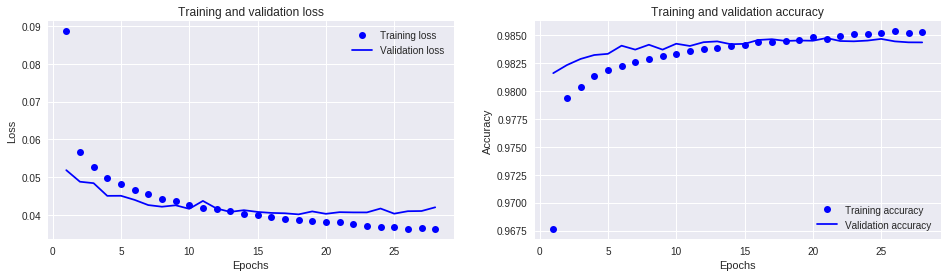

In [13]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 46s 1ms/step
([0.0411928105783625, 0.9847511476415574], 0.9835230322297693)
